# Lesson 7 : Multi-label classification

- Video >> https://youtu.be/0frKXR-2PBY
- wiki >> http://forums.fast.ai/t/part-2-lesson-9-in-class/14028/1
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-9-5f0cf9e4bb5b


<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/07_multi label classification/cours_7.png" width="80%">

From the previous lesson, we have learnt how to detect and classify an object from the same model.
Now, we want to extend to multiple label classification. But, we know already how to do that, right?

In [1]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-bfzo5bfo
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras.git /tmp/pip-req-build-bfzo5bfo
  Resolved https://github.com/keras-team/keras.git to commit 08ad93b77488f911328da6a676f04709b6e9f788
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-rajz2uo4
  Running command git clone --filter=blob:none --quiet https://github.com/valeoai/dl_utils.git /tmp/pip-req-build-rajz2uo4
  Resolved https://github.com/valeoai/dl_utils.git to commit abd677290660c7c090155d5e593fe699edf98203
  Preparing metadata (setup.py) ... done


In [2]:
import keras
from keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#!rm -Rf VOCdevkit


## Setup (as previous lesson)

In [5]:
import os
if not os.path.isdir('./VOCdevkit/'):
    !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    #! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    #! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007



In [6]:
! cp /content/drive/MyDrive/Colab\ Notebooks/Dl_Dr_sallab_youtube/ved_8/pascal_train2007.json  VOCdevkit/VOC2007/pascal_train2007.json


In [7]:
from pathlib import Path
import json


PATH = Path('VOCdevkit/VOC2007')
BD = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

data_category = dict((o[ID], o['name']) for o in BD[CATEGORIES])
data_filename = dict((o[ID], o[FILE_NAME]) for o in BD[IMAGES])
data_ids = [o[ID] for o in BD[IMAGES]]

IMG_PATH = PATH/'JPEGImages'

Notice this time, we dont only get the largest box, but all of them


In [8]:
import collections

def get_annotation():
    annotations = collections.defaultdict(lambda:[])
    for o in BD[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            annotations[o[IMG_ID]].append((bb,o[CAT_ID]))
    return annotations

train_annotation = get_annotation()

In [9]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [10]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], data_category[c], sz=16)

def draw_idx(i):
    im_a = train_annotation[i]
    im = open_image(IMG_PATH/data_filename[i])
    draw_im(im, im_a)

# Multi class classification

### 1: The Data

In [11]:
mc = []
for o in data_ids:
    c = np.zeros(len(data_category),dtype=int)
    for p in train_annotation[o]:
        c[p[1]-1]=1               # p[1] is cat_id  ,c[]=10001001   one in cat
    mc.append(c)

mc = np.asarray(mc)# Not One Hot Encoding, but could include multi-1's
class_name=[o['name'] for o in BD[CATEGORIES]]# Reverse mapping from ID to class name
filename = [data_filename[o] for o in data_ids]


In [12]:
import pandas as pd

df=pd.DataFrame(mc,columns=class_name)
df['filename'] = pd.Series(filename, index=df.index)

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))

    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))

    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

Notice how the we can have more that 1 for each image.

In [13]:
df.head()

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,dog,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,filename
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,000005.jpg
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,000007.jpg
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,000009.jpg
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,000012.jpg
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,000016.jpg


In [14]:
# our batch size
bs=32
# define the size of our input data
sz=224

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_batches = train_datagen.flow_from_dataframe(df_train,
                                                  IMG_PATH,
                                                  x_col='filename',
                                                  y_col=class_name,
                                                  has_ext=True,
                                                  target_size=(sz, sz),
                                                  color_mode='rgb',
                                                  classes=None,
                                                  class_mode='other',
                                                  batch_size=bs,
                                                  shuffle=True)

valid_batches = valid_datagen.flow_from_dataframe(df_valid,
                                                  IMG_PATH,
                                                  x_col='filename',
                                                  y_col=class_name,
                                                  has_ext=True,
                                                  target_size=(sz, sz),
                                                  color_mode='rgb',
                                                  classes=None,#list(train_batches.class_indices),
                                                  class_mode='other',
                                                  batch_size=bs,
                                                  shuffle=False)

NbClasses = len(class_name)

Found 3507 validated image filenames.
Found 1504 validated image filenames.


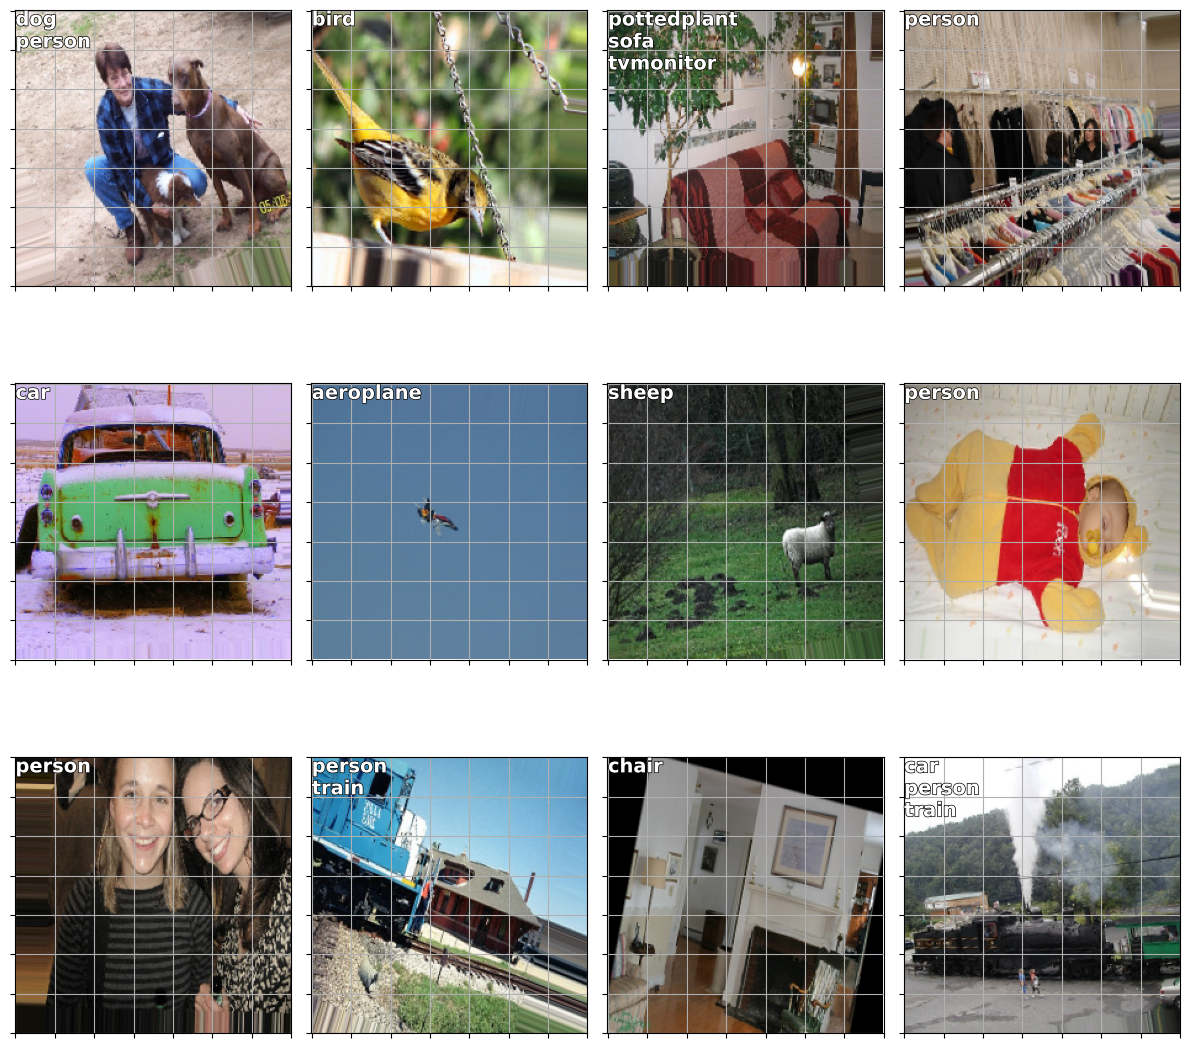

In [15]:
from dlutils import unpreprocess

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for i,ax in enumerate(axes.flat):
    x,y = next(train_batches)
    image = x[0]

    ind = np.where(y[0,:]==1)
    b = '\n'.join(data_category[o+1] for o in ind[0])
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), b)

plt.tight_layout()

### 2: The model

In [16]:
sz=224
bs=64

net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
for layer in net.layers:
        layer.trainable=False

y = net.output
y = Flatten()(y)
y = Dropout(0.5)(y)

output_layer_class = Dense(NbClasses, activation='sigmoid', name='layer_class')(y)

model = Model(inputs=net.input, outputs=output_layer_class)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_class (Dense)             │ (None, 20)             │       501,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,216,468 (58.05 MB)

 Trainable params: 501,780 (1.91 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### 3: The optimizer

In [19]:
optimizer=Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=['accuracy'])

We have to pay attention to our Loss function here. Indeed, we predict multi categories per image. Y is no more a vector of zeros and a one somewhere, but instead, we have multiple one, as much as the number of label in the image.

As a consequence, we can not use anymore <kbd>SoftMax</kbd> as an activation, but a <kbd>sigmoid</kbd> instead. Further more, as we have changed our activation layer, we have also to update our <kbd>Loss</kbd> function. <kbd>Categorical_crossentropy</kbd> does not work anymore as we have multi-labels. As each activation is supposed to be fully independant, we select <kbd>binary_crossentropy</kbd>: in a defined image, there is no relationship between label cat and label chair!

### 4: training phase

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 85s 654ms/step - accuracy: 0.2017 - loss: 1.9768 - val_accuracy: 0.4375 - val_loss: 1.0199
Epoch 2/10
  1/109 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - accuracy: 0.3750 - loss: 1.3883

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.3750 - loss: 1.3883 - val_accuracy: 0.4402 - val_loss: 1.0170
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 110s 567ms/step - accuracy: 0.3845 - loss: 1.1971 - val_accuracy: 0.5445 - val_loss: 0.8727
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.5000 - loss: 1.0333 - val_accuracy: 0.5445 - val_loss: 0.8749
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 72s 557ms/step - accuracy: 0.4699 - loss: 0.9879 - val_accuracy: 0.5791 - val_loss: 0.8044
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.5312 - loss: 0.8332 - val_accuracy: 0.5798 - val_loss: 0.8062
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 558ms/step - accuracy: 0.5194 - loss: 0.8546 - val_accuracy: 0.6011 - val_loss: 0.7621
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.5312 - loss: 0.8899 - val_accuracy: 0.6011 - val_loss: 0.7612
Epoch 9/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 62s 573ms/step - accuracy: 0.5491 - loss: 0.7681 - val_accur

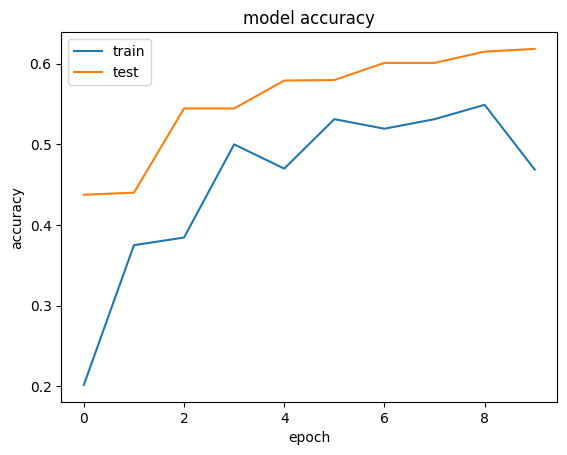

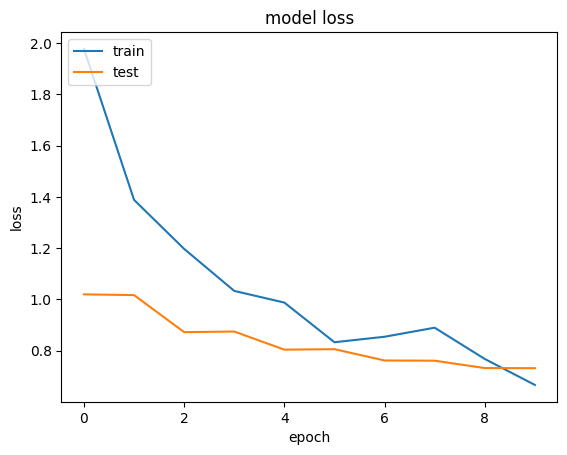

In [20]:
epochs = 10

history = model.fit(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 5: unfreeze few layers

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_class (Dense)             │ (None, 20)             │       501,780 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,220,030 (61.87 MB)

 Trainable params: 7,581,204 (28.92 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 1,003,562 (3.83 MB)

None
Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 63s 573ms/step - accuracy: 0.5822 - loss: 0.7024 - val_accuracy: 0.6210 - val_loss: 0.7409
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.6875 - loss: 0.8585 - val_accuracy: 0.6243 - val_loss: 0.7404
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 546ms/step - accuracy: 0.6029 - loss: 0.6489 - val_accuracy: 0.6350 - val_loss: 0.7207
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.5000 - loss: 0.5857 - val_accuracy: 0.6350 - val_loss: 0.7216
Epoch 5/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 60s 552ms/step - accuracy: 0.6078 - loss: 0.5993 - val_accuracy: 0.6316 - val_loss: 0.6958
Epoch 6/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.5625 - loss: 0.6285 - val_accuracy: 0.6310 - val_loss: 0.6962
Epoch 7/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 61s 562ms/step - accuracy: 0.6250 - loss: 0.5641 - val_accuracy: 0.6456 - val_loss: 0.6942
Epoch 8/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.6250 - loss: 0.52

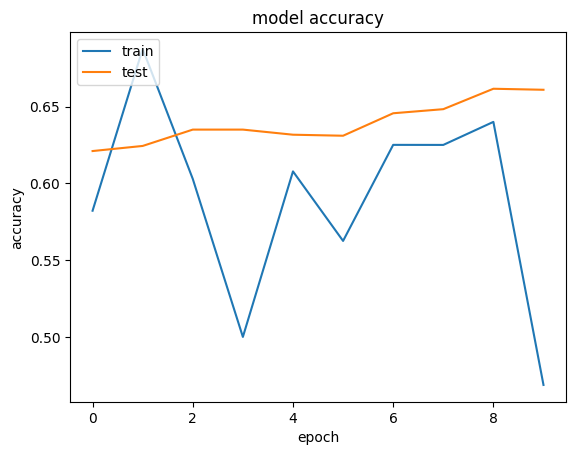

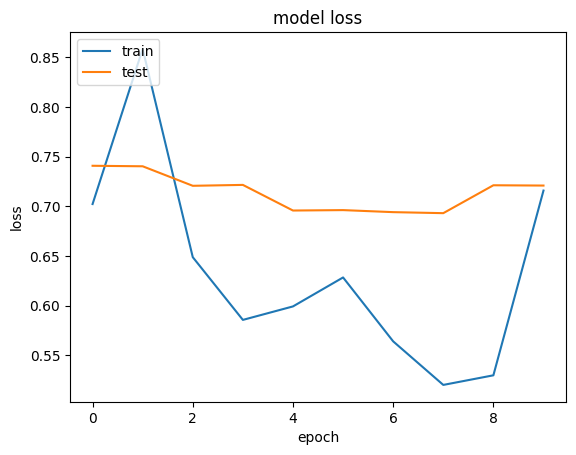

In [21]:
FREEZE_LAYERS = 14

# free the first layers
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True
print(model.summary())
epochs = 10

history = model.fit(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size)

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 6: check the result

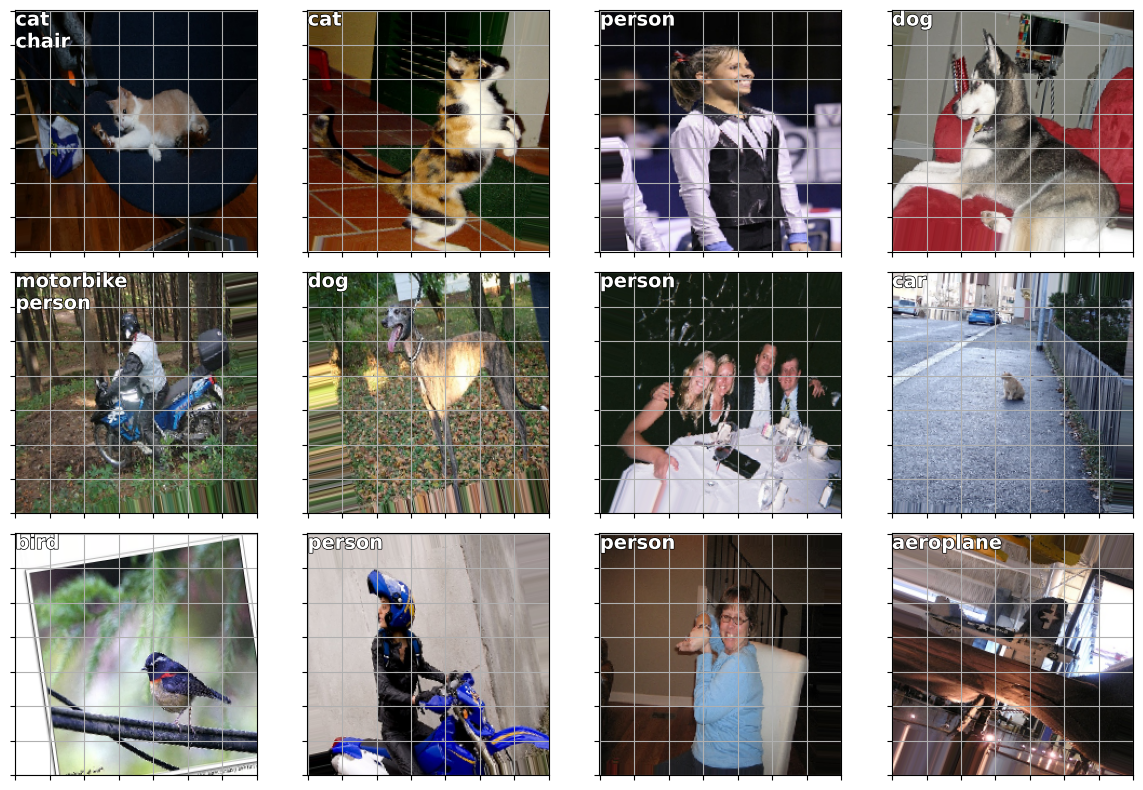

In [23]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x,y = next(train_batches)
    image = x[0]
    yPred = model.predict(np.expand_dims(image, axis=0), batch_size=None, verbose=0, steps=None)
    ind = np.where(yPred[0]>0.4)
    b = '\n'.join(data_category[o+1] for o in ind[0])
    ax = show_img(unpreprocess(image,'none','none'), ax=ax)
    draw_text(ax, (0,0), b)

plt.tight_layout()